# Single Cell apoptosis

As decribed in [Monier et al. 2015](http://www.nature.com/nature/journal/v518/n7538/full/nature14152.html).

We start with a simple hexagonal apical mesh with cylindrical symmetry. 

#### Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue import Sheet
from tyssue import config

from tyssue import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel

from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw import sheet_view
from tyssue.io.hdf5 import load_datasets

### Loading the datasets and specifications

Here it is a cylindrical hexagonal mesh.

In [12]:
# Read pre-recorded datasets
h5store = 'data/small_hexagonal.hf5'
from tyssue.io.hdf5 import save_datasets, load_datasets

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
# Corresponding specifications
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

# Model
nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs)

sheet.get_opposite()
live_edges = sheet.edge_df[sheet.edge_df['opposite']==-1].index
dead_src = sheet.edge_df.loc[live_edges, 'srce'].unique()

### Boundary conditions
sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

### First energy minimization

In [13]:

min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


### Custom display function

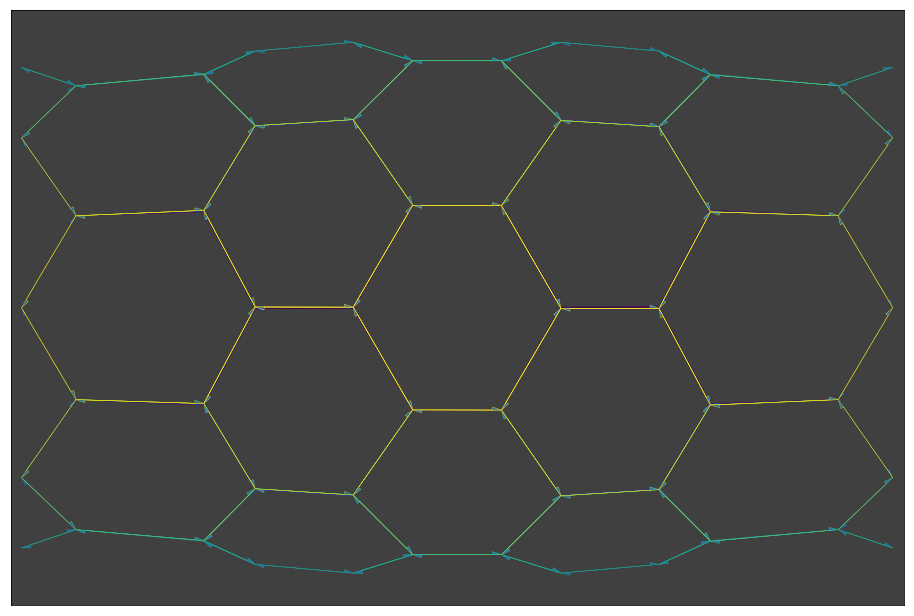

In [14]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], mode='2D', **draw_specs)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-10, 10)
    ax.set_facecolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((16, 19))
    return fig, ax

fig, ax = leg_joint_view(sheet)


### Choosing an apoptotic cell 

In [15]:
apoptotic_cell = 16
print('Apoptotic cell position:\n{}'.format(sheet.face_df.loc[apoptotic_cell, sheet.coords]))
apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Apoptotic cell position:
x   -7.673377
y    3.197728
z   -5.092089
Name: 16, dtype: float64
Indices of the apoptotic vertices: [40 51 41 50 52 53]


Cell behaviours, such as division or apoptosis, are defined as a series of unit changes in the tissue, such as the cell growth, or the abscission of the cell face once division is complete. For a given behavior, the next step often depends on the current state. This is managed by an EventManager object, which runs the behaviour.





In [16]:
from tyssue.behaviors.sheet import apoptosis
from tyssue.behaviors import EventManager


manager = EventManager('face', 'test.log')


sheet.settings['apoptosis'] = {
    'shrink_rate': 0.5,
    'critical_area': 8.,
    'radial_tension': 0.2,
    'contractile_increase': 0.3,
    'contract_span': 2
    }

sheet.face_df['id'] = sheet.face_df.index.values
manager.append(apoptosis, face_id=apoptotic_cell,
               **sheet.settings['apoptosis'])


In [8]:
manager.next

deque([(<function tyssue.behaviors.sheet.apoptosis_events.apoptosis(sheet, manager, **kwargs)>,
        {'face_id': 16,
         'shrink_rate': 0.5,
         'critical_area': 8.0,
         'radial_tension': 0.2,
         'contractile_increase': 0.3,
         'contract_span': 2})])

We perform the events at each time points to run the simulation

In [9]:
t = 0
stop=100
while manager.current and manager.clock < stop:
    manager.execute(sheet)
    manager.clock += 1
    res = solver.find_energy_min(sheet, geom, model, **min_settings)
    fig, ax = leg_joint_view(sheet)
    plt.savefig('single_apopto_{:03d}.png'.format(manager.clock))
    plt.close(fig)
    manager.update()

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


### 3D view with ipyvolume

In [10]:
color = sheet.vert_df['y']
fig, mesh = sheet_view(sheet, coords=['z', 'x', 'y'], mode='3D',
                       face={'visible':True, 
                             'color':sheet.face_df['area'] })
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

Provided you have ImageMagick installed, we can convert the output to a nice gif, like so:

In [11]:
%%bash
convert single_apopto*.png single_apopto.gif
rm single_apopto*.png

![Gif of the resulting simulation](single_apopto.gif)